In [5]:
import datajoint as dj
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
dj.config['database.host'] = 'at-database3.stanford.edu'
dj.config['database.user'] = 'pavi'
dj.config['database.password'] = 'pavi#1'

In [2]:
csrf = dj.create_virtual_module("george_csrf","george_csrf")
#events = (csrf.EyeTracePreprocessed.EyeEventsFullSession() & session_dict).fetch()
acq = dj.create_virtual_module("acq","acq")
ephys = dj.create_virtual_module("ephys","ephys")
stim = dj.create_virtual_module("stimulation", "stimulation")

[2024-11-27 03:20:49,996][INFO]: Connecting pavi@at-database3.stanford.edu:3306
[2024-11-27 03:20:50,044][INFO]: Connected pavi@at-database3.stanford.edu:3306


In [3]:
key = dict(session_start_time=3638885582960)

In [4]:
ephys.Spikes() & key

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,ephys_start_time start session timestamp,detect_method_num detection method index,sort_method_num clustering method index,unit_id The spike data,electrode_num The electrode number,spike_times The spike timing data,mean_waveform The spike waveform data,spike_file_path The file containing the spike data,multi_trigger_fraction fraction of spikes triggered multiple times
30,1,3638885582960,3638885586600,5,4,1,1,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc1.Htt,0.00205973
30,1,3638885582960,3638885586600,5,4,2,2,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc2.Htt,0.00514139
30,1,3638885582960,3638885586600,5,4,3,3,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc3.Htt,0.0477643
30,1,3638885582960,3638885586600,5,4,4,4,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc4.Htt,0.0349511
30,1,3638885582960,3638885586600,5,4,5,5,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc5.Htt,0.0180966
30,1,3638885582960,3638885586600,5,4,6,6,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc6.Htt,0.0213648
30,1,3638885582960,3638885586600,5,4,7,7,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc7.Htt,0.02014
30,1,3638885582960,3638885586600,5,4,8,8,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc8.Htt,0.0217688
30,1,3638885582960,3638885586600,5,4,9,9,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc9.Htt,0.0108388
30,1,3638885582960,3638885586600,5,4,10,10,=BLOB=,=BLOB=,/processed/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-06/spikes/SiliconProbesV2/Sc10.Htt,0.00906078


In [5]:
spike_times = ((ephys.Spikes & csrf.EyeMovements() )& dict(session_start_time=3638973674012,)).fetch("spike_times")

In [6]:
np.vstack(spike_times).squeeze().max() - np.vstack(spike_times).squeeze().min()

np.float64(8688184.591272362)

In [7]:
np.vstack(spike_times).squeeze().max()

np.float64(8690756.19410583)

In [8]:
np.vstack(spike_times).squeeze().min()

np.float64(2571.6028334684834)

# Spikes

In [9]:
import datajoint as dj
from tqdm import tqdm
import numpy as np

In [10]:
def reflection_pad_both(data, pad_len):
    # reflection pads both sides of a 1D array
    reflection = data[::-1]
    padded_data = np.concatenate((reflection[-pad_len:], data, reflection[:pad_len]))
    return padded_data

def smooth_data_fixed_length(raster_data, filt_size=101, filt_sigma=10, target_length=None):
    x = np.linspace(-filt_size // 2, filt_size // 2, filt_size)  # Gaussian filter
    filt = np.exp(-(x**2) / (2 * filt_sigma**2))
    filt /= np.sum(filt)  # Normalize the filter

    smoothed_data = []
    
    for spikes in raster_data:
        # Reflection pad each neuron's data based on its length
        pad_len = int((filt_size - 1) / 2)
        padded_spikes = reflection_pad_both(spikes.reshape(-1), pad_len)

        # Check if the array is 1D
        if len(padded_spikes.shape) > 1:
            raise ValueError(f"Expected 1D array but got {padded_spikes.shape}")

        # Convolve with Gaussian filter and store the smoothed result
        smoothed_spikes = np.convolve(padded_spikes, filt, mode='valid')

        if target_length is not None:
            if len(smoothed_spikes) < target_length:
                # Pad to the right if the smoothed array is too short
                smoothed_spikes = np.pad(smoothed_spikes, (0, target_length - len(smoothed_spikes)), mode='constant')
            else:
                # Downsample if the smoothed array is too long
                smoothed_spikes = np.interp(
                    np.linspace(0, len(smoothed_spikes) - 1, target_length),
                    np.arange(len(smoothed_spikes)),
                    smoothed_spikes
                )
        smoothed_data.append(smoothed_spikes)
    
    return smoothed_data

### let's try it out

In [11]:
last_spike_time = np.max([np.max(unit) for unit in spike_times])
last_spike_time

np.float64(8690756.19410583)

In [12]:
res_arr_size = int(last_spike_time)
res_arr_size

8690756

In [13]:
raster_data = spike_times
filt_size=101
filt_sigma=10 
target_length=res_arr_size

In [14]:
x = np.linspace(-filt_size // 2, filt_size // 2, filt_size)  # Gaussian filter
filt = np.exp(-(x**2) / (2 * filt_sigma**2))
filt /= np.sum(filt)  # Normalize the filter


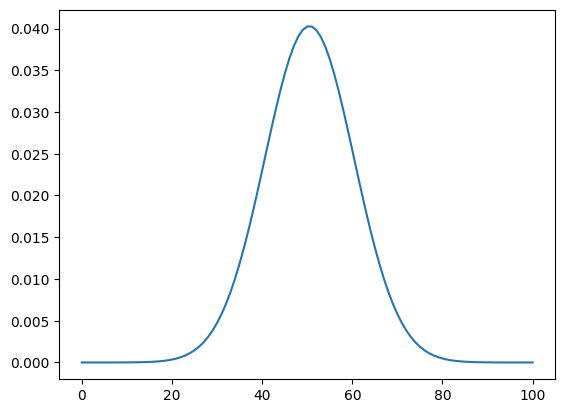

In [15]:
plt.plot(filt)

In [16]:
spikes = raster_data[0]

In [17]:
# Reflection pad each neuron's data based on its length
pad_len = int((filt_size - 1) / 2)
padded_spikes = reflection_pad_both(spikes.reshape(-1), pad_len)

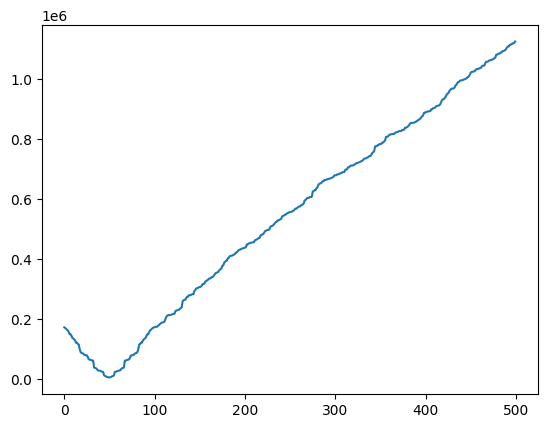

In [18]:
plt.plot(padded_spikes[:500])

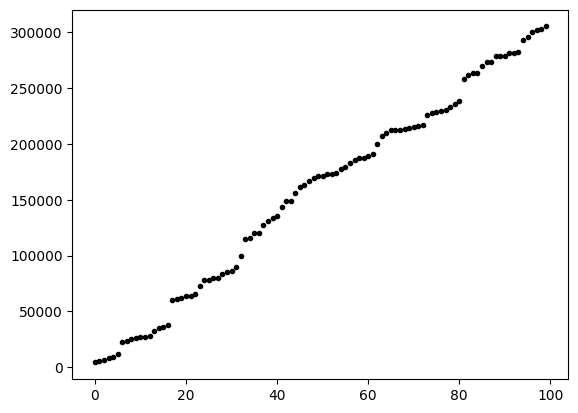

In [19]:
plt.plot(spikes[:100,0], '.k')

In [20]:
padded_spikes[:5000]

array([ 171354.62514152,  169334.30112656,  166697.09264209, ...,
       8507576.1148716 , 8508119.94158291, 8508497.66838338])

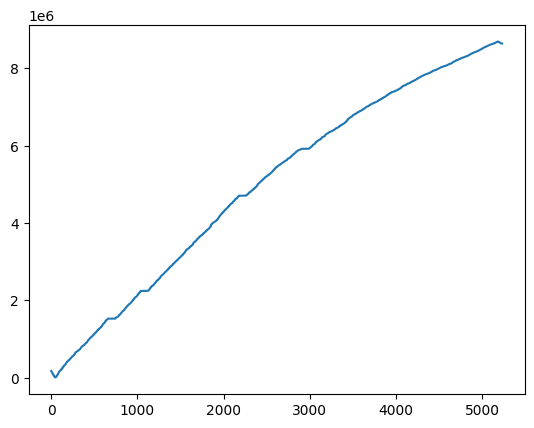

In [21]:
plt.plot(padded_spikes)

In [22]:
smoothed_spikes = np.convolve(padded_spikes, filt, mode='valid')

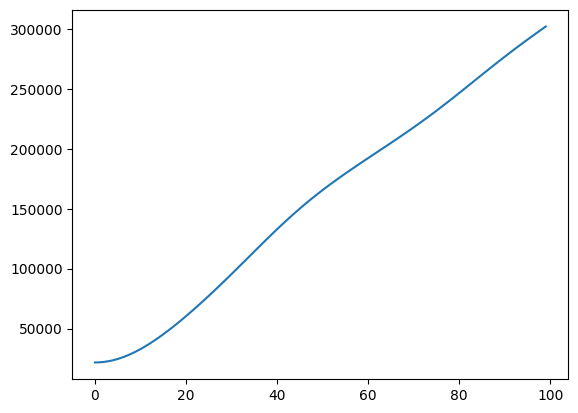

In [23]:
plt.plot(smoothed_spikes[:100])

In [25]:
smoothed_spikes = np.pad(smoothed_spikes, (0, target_length - len(smoothed_spikes)), mode='constant')

In [ ]:
plt.plot(smoothed_spikes)

In [ ]:
if target_length is not None:
    if len(smoothed_spikes) < target_length:
        # Pad to the right if the smoothed array is too short
        smoothed_spikes = np.pad(smoothed_spikes, (0, target_length - len(smoothed_spikes)), mode='constant')
    else:
        # Downsample if the smoothed array is too long
        smoothed_spikes = np.interp(
            np.linspace(0, len(smoothed_spikes) - 1, target_length),
            np.arange(len(smoothed_spikes)),
            smoothed_spikes
        )
smoothed_data.append(smoothed_spikes)

# eye movements

In [23]:
acq.Sessions & csrf.EyeMovements()

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,session_stop_time end of session timestamp,experimenter name of person running exp,session_path path to the data,session_datetime readable format of session start,hammer,recording_software software used to record the data
30,1,3638885582960,3638893002455,Tori,/raw/Dennis/2019-04-23_12-33-02,2019-04-23 12:33:02,0,Acquisition2.0
30,1,3638973674012,3638982377196,Tori,/raw/Dennis/2019-04-24_13-01-13,2019-04-24 13:01:14,0,Acquisition2.0
30,1,3639492658943,3639499010707,Tori,/raw/Dennis/2019-04-30_13-10-58,2019-04-30 13:10:58,0,Acquisition2.0
30,3,3790954384887,3790961792928,Gabby,/raw/Dennis/2024-02-16_12-53-04,2024-02-16 12:53:04,0,Acquisition2.0
30,3,3791216067773,3791223474548,Gabby,/raw/Dennis/2024-02-19_13-34-27,2024-02-19 13:34:27,0,Acquisition2.0
30,3,3791303340046,3791310764911,Gabby,/raw/Dennis/2024-02-20_13-48-59,2024-02-20 13:49:00,0,Acquisition2.0
30,3,3791388328061,3791395751007,Gabby,/raw/Dennis/2024-02-21_13-25-27,2024-02-21 13:25:28,0,Acquisition2.0
30,3,3791564082786,3791571539496,Gabby,/raw/Dennis/2024-02-23_14-14-42,2024-02-23 14:14:42,0,Acquisition2.0
31,1,3653578665399,3653586699133,Tori,/raw/Conan/2019-10-10_13-57-45,2019-10-10 13:57:45,0,Acquisition2.0


In [54]:
eye_coords, eye_degrees, pupil_size = (csrf.EyeMovements() & dict(session_start_time=3638885582960, image_number=4)).fetch("eye_coords", "eye_degrees", "pupil_size")

In [55]:
eye_coords.shape

(528,)

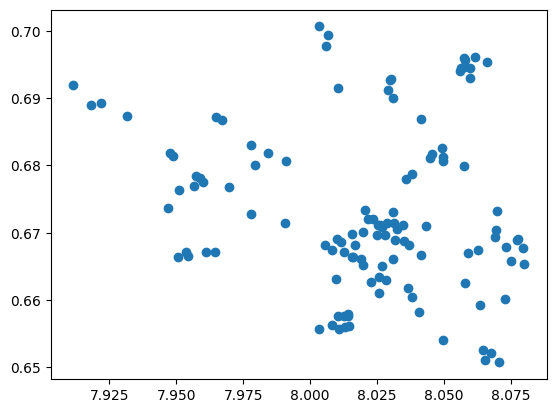

In [56]:
plt.plot(*np.stack(eye_coords[1]).T, 'o')

In [51]:
eye_coords, eye_degrees, pupil_size = (csrf.EyeMovements() & dict(session_start_time=3638885582960, image_number=1)).fetch("eye_coords", "eye_degrees", "pupil_size")

In [52]:
eye_coords.shape

(528,)

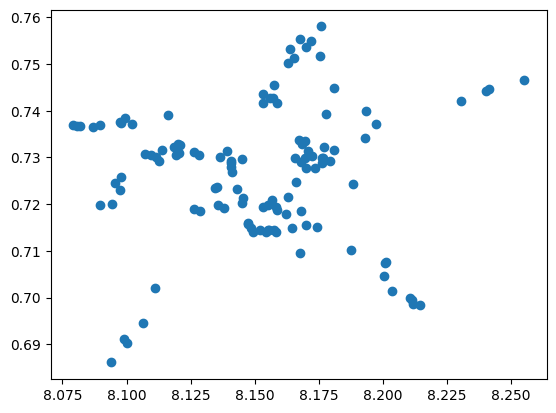

In [53]:
plt.plot(*np.stack(eye_coords[1]).T, 'o')

In [46]:
key = dict(session_start_time=3638885582960)

In [ ]:
acq.

In [35]:
acq.TberPulses()

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,stim_start_time timestamp for stimulation start,tber_pulse_time pulse time
0,1,3398184067536,3398184105204,3398184116159
0,1,3398184067536,3398184105204,3398184121129
0,1,3398184067536,3398184105204,3398184125924
0,1,3398184067536,3398184105204,3398184130692
0,1,3398185136890,3398186557363,3398188132380
0,1,3398190204188,3398190422533,3398190434034
0,1,3398190204188,3398190422533,3398190438206
0,1,3398260519682,3398262428150,3398262440384
0,1,3398260519682,3398262428150,3398262507055
0,1,3398260519682,3398262755896,3398262762068


In [105]:
acq.Stimulation & key

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,stim_start_time timestamp for stimulation start,stim_stop_time end of stimulation timestamp,stim_path path to the stimulation data,exp_type type of experiment,total_trials total number of trials completed,correct_trials number of correct trials,incorrect_trials number of incorrect trials
30,1,3638885582960,3638885599001,3638892994328,/stimulation/Dennis/2019-04-23_12-33-19,CenterSurroundExperiment,2145,528,0


In [106]:
(acq.BehaviorTraces() & key)

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,stim_start_time timestamp for stimulation start,beh_start_time timestamp for recordng start,beh_stop_time end of recording timestamp,beh_path path to the behavioral data,beh_traces_type type of recording
30,1,3638885582960,3638885599001,3638885599011,3638892994853,/raw/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-18/BehaviorData%d.h5,analog


In [109]:
3638885599011-3638885582960


16051

In [2]:
filename = "/mnt/mscratch1/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-18/BehaviorData0.h5"

In [2]:
import datajoint as dj
import os
import h5py
import scipy.io
import numpy as np
from scipy.signal import decimate
import pandas as pd

In [3]:
filename = '/mnt/mscratch1/Dennis/2019-04-23_12-33-02/2019-04-23_12-33-18/BehaviorData%d.h5'

In [7]:
br = BaseReaderElectrophysiology(filename, )

In [9]:
eh = np.array(br.match_channels('Eye Horizontal').tolist())


i did my job


In [10]:
from matplotlib import pyplot as plt

In [11]:
eh.shape

(14790223,)

In [12]:
14790223 / 1000

14790.223

In [13]:
14790 /3600

4.108333333333333

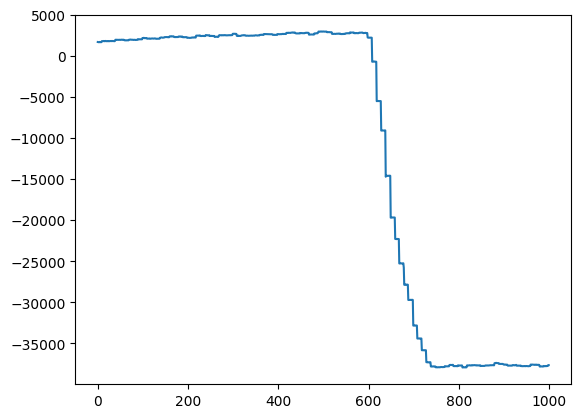

In [18]:

plt.plot(eh[:1000])

In [14]:
br.Fs

array([2000.])

In [26]:
br.fp.attrs["channelNames"]

np.bytes_(b'Eye Horizontal,Eye Vertical,Photodiode,PupilSizeIn\r\n')

In [6]:
import h5py
import numpy as np

class BaseReaderElectrophysiology:
    def __init__(self, file_name, channels=None):
        self.file_name = file_name
        self.fp = h5py.File(file_name, 'r',  driver='family',memb_size=2147483648)
        sz = self.fp['data'].shape
        self.nb_channels = sz[0]
        self.nb_samples = sz[1]
        self.ch_names = self.fp.attrs['channelNames'].decode('UTF-8').strip().split(',')
        self.Fs = self.fp.attrs['Fs']
        self.t0 = self.fp.attrs.get('t0', 0)
        self.scale = self.fp.attrs['scale']
        #self.eh = self.fp['data'][0][:]
        #self.ev = self.fp['data'][1][:]
        #self.ps = self.fp['data'][3][:]

        

    def match_channels(self, channel):
       
        if not (isinstance(channel, str)):
            raise ValueError('channel name must be a string')
        
        if not (channel in self.ch_names):
            raise KeyError('channel name not valid. Channel name can only be one of Eye Horizontal, Eye Vertical, Photodiode, PupilSizeIn')
    

        ch_index = self.ch_names.index(channel)
        ch_data = self.fp['data'][ch_index][:]
        print('i did my job')
        
        return ch_data
    
    def get_sample_index(self, t):
        # Returns the sample indices 'idx' for the vector of timestamps 't'.

        #print("the value of t0 is ", self.t0)
        if not (self.t0 > 0):
            raise ValueError('t0 has not been updated in this file!')
        
        idx = np.round(1e-3 * (t - self.t0) * self.Fs) + 1
        idx[idx < 1] = np.nan
        idx[idx > self.nb_samples] = np.nan
        return idx